In [126]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
# This is a template notebook for extracting the project disk summary. To run this, do the following.

# 1. Set an environment variable called PROJECT and set it to the project name that you want to study.
# 2. Go to the terminal and run `jupyter-nbconvert --ExecutePreprocessor.timeout=-1 --execute ProjectDiskSummary-Template.ipynb`

# Please note that extracting the disk info using 'find' command works only in linux. If you are in windows, you'll have to
# generate that file outside of this notebook.

In [2]:
import os
import time
import pandas as pd
import subprocess
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

In [6]:
project = os.environ['PROJECT']

In [7]:
folder_path = '/project/{}'.format(project)

In [8]:
%matplotlib inline

In [9]:
## Some useful functions

In [10]:
# Function to display text in large size
def shout(message, size='h1', color='black', css=""):
    return display(HTML('<{0} style="color:{2};{3}">{1}</{0}>'.format(size, message, color, css)))

# Funciton to return the username from userid
import pwd
def finger(id):
    try:
        return pwd.getpwuid(int(id)).pw_gecos
    except:
        return 'yy' + str(id)
    
#increase the field width
pd.set_option('display.max_colwidth',-1)

In [11]:
shout(
    "Project disk summary for {}".format(
        folder_path), 
    color="grey", 
    size="h1")

Any questions, contact [Najeem Muhammed](mailto:najeem.muhammed@gknaerospace.com)

In [12]:
## Generating the file list

In [13]:
out_file = os.path.abspath('/project/nobackup/Shared_VAI/DiskSpaceSummary/files_list_{}.out'.format(project))

In [14]:
shout(
    "Generating the file data for analysis for all files in folder {}........".format(
        folder_path), 
    color="grey", 
    size="h3")

In [ ]:
%%time
# The following command works only in linux
!cd $folder_path; find -printf '%h|%f|%s|%U|%a|%t|%d|%S|%y\n' >$out_file 2>/dev/null

In [ ]:
## Reading the Data

In [15]:
files = pd.read_csv(out_file, sep='|', header=None, low_memory=False)

In [16]:
files = files.dropna()

In [17]:
## Setting the dataframe columns

In [18]:
files.columns = ['Folder', 'File', 'Size', 'User', 'DateAccessed', 'DateModified', 'Depth', 'Sparseness', 'ItemType']

In [19]:
## Converting the date from string to date objects

In [20]:
files.DateAccessed = pd.to_datetime(files.DateAccessed)
files.DateModified = pd.to_datetime(files.DateModified)

In [21]:
## Converting the size from bytes to Gbs

In [22]:
files.Size = files.Size.apply(lambda x: round(x/2**30, 2))

In [23]:
## Finding the username from user ID

In [24]:
files["UserName"] = files.User.apply(finger)

In [25]:
## Finding the project folder and file extension

In [26]:
files["Type"] = files.File.apply(lambda x: os.path.splitext(x)[-1])

In [27]:
## New field to show the access/modified months only

In [28]:
files["Junk"] = False
# File extensions which are usually junk files
files.loc[files.Type.str.lower().isin([".esav", ".osav", ".emat", ".page", ".dbb", ".full", '.dab', '.cmf']), ["Junk"]] = True
# File that are 6 characters long and with mixed case
files.loc[(files.Type.str.contains("[A-Z]", regex=True)) & (files.Type.apply(lambda x: len(x) == 7)), ["Junk"]] = True
# Files which are backup files
files.loc[files.Type.str.contains("~"), ["Junk"]] = True
# Files which are backup files
files.loc[files.Type.str.contains("ansabort.db"), ["Junk"]] = True
# Files which are backup files
files.loc[files.Type.str.contains("delete"), ["Junk"]] = True
# File extensions that are too long
files.loc[files.Type.apply(lambda x: len(x) > 10), ["Junk"]] = True
# LN files
files.loc[files.Type.str.lower().str.contains('ln[0-9]+', regex=True), ["Junk"]] = True
# LN files
files.loc[files.Type.str.lower().str.contains('pc[0-9]+', regex=True), ["Junk"]] = True
# Nonlinear diagnostics files
files.loc[files.Type.str.lower().str.contains('nr[0-9]+', regex=True), ["Junk"]] = True

In [29]:
fcount = files.Size.count()
fsize = files.Size.sum()
shout("{} files with a total size of {} Gb".format(fcount, round(fsize, 1)))

In [30]:
shout("10 Largest files")
files.nlargest(10, columns=["Size"])[["Size", "File", "Folder"]]

,Size,File,Folder
146332,93.73,vols_10191186_F00_01_LCF_Run.rst,./NSAIMC/A320NEO/G5_G6/vols_10191186_block2_comp_6/F00_01_LCF/mission_run
428386,73.92,vols_10164904_F00_02_IMC_25BLD_HT_LCF_Strt1_pres_updated.rst,./BA_IMC/G5_G6/Vols_10164904_IMC_25BLD_HardTool/Analyses/F00_02_LCF_PT2580/Runfiles
193577,65.79,VOLS_10207183_FL1_02_E_flange_submodel_LCF.rst,./NSAIMC/IRKUT/G5_G6/VOLS_10207183_Irkut_IMC_cert/FL1_02_E_flange/Submodel/LCF
184457,59.69,VOLS_10207183_F00_01_LCF_Run.rst.gz,./NSAIMC/IRKUT/G5_G6/VOLS_10207183_Irkut_IMC_cert/F00_01_LCF/mission_run
122327,52.54,Irkut_loop2_LPC4flg_LCF_submodel.rst,./NSAIMC/A320NEO/MRB/VOLS_10215992_NEO_NCR/LPC_Irkut_loop2_rst
192233,42.70,Irkut_LCF_submodel_Cert_1.5Nom_with_corrected_sign.rst,./NSAIMC/IRKUT/G5_G6/VOLS_10207183_Irkut_IMC_cert/FL2_01_LPC4_flange/Submodel/LCF
422870,42.57,vols_10228446_E_flange_Assy_LCF_mission.rst,./BA_IMC/G5_G6/Vols_10228446_IMC_Loop3_CS300/Analysis/FL1_E-Flange/LCF/Assy
353147,42.18,Vols_10219180_EIS_Loop1_7_FW_FBO_EDnL_and_acel.rst,./Structures/G5_G6/Vols_10219180_FW_EIS_Loop1_7Loads/Analysis/01_FBO/rst
415314,40.25,vols_10197516_FL10_01_LCF_B3Flange.rst,./BA_IMC/G5_G6/Vols_10197516_IMC_25BLD_HardTool_Loop2_CS300_loads/Analyses/F10_B3_Flange/Sub
423407,40.15,vols_10228446_B00_01_IMC_BA_Loop3CS300_FBO.rst,./BA_IMC/G5_G6/Vols_10228446_IMC_Loop3_CS300/Analysis/B00_01_FBO


In [31]:
shout("Largest Folders (Size)")
files.groupby('Folder').Size.sum().nlargest(20).to_frame()

,Size
Folder,
./NSAIMC/A320NEO/Archive/Analysis/VOLS_10191185/EM0_04_Engine_Mount_Well/DT,122.78
./NSAIMC/IRKUT/G5_G6/VOLS_10215817_Irkut_FW_P107/S00_01_Strength/00_PressFit_Pretension,122.37
./NSAIMC/A320NEO/Archive/Analysis/VOLS_10191185/FS2_03_Engine_Mount_Failed/DT_case1,101.08
./BA_IMC/G5_G6/Vols_10193179_FW_EIS_Common_Embraer/Analyses/G00_01_General/Pretension,100.75
./NSAIMC/A320NEO/G5_G6/vols_10191186_block2_comp_6/F00_01_LCF/mission_run,96.75
./BA_IMC/MRB/Vols_10164904_IMC_25BLD_HardTool_EIS/24K_IMC_Casting_Imperfections_Study/FW_IMC_Flange/Ansys,87.33
./BA_IMC/G5_G6/Vols_10164904_IMC_25BLD_HardTool/Analyses/F00_02_LCF_PT2580/Runfiles,77.93
./BA_IMC/Embraer/Vols_10230911_Embraer_FW_Redesign/Analysis/Pretension,71.68
./BA_IMC/G5_G6/Vols_10239483_FW_PW5379945/Analysis/F00_01_LCF,70.36


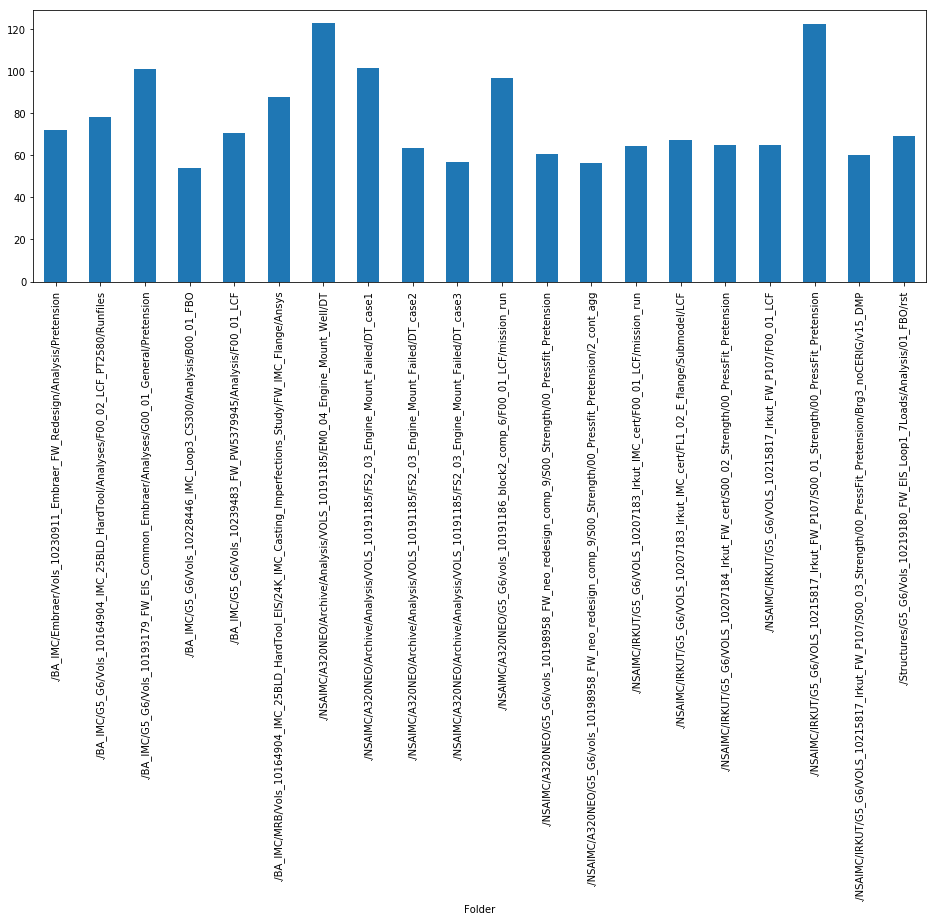

In [32]:
big_folders = list(files.groupby('Folder').Size.sum().nlargest(20).index)
files[files.Folder.isin(big_folders)].groupby("Folder").Size.sum().plot(kind='bar', figsize = (16, 5))

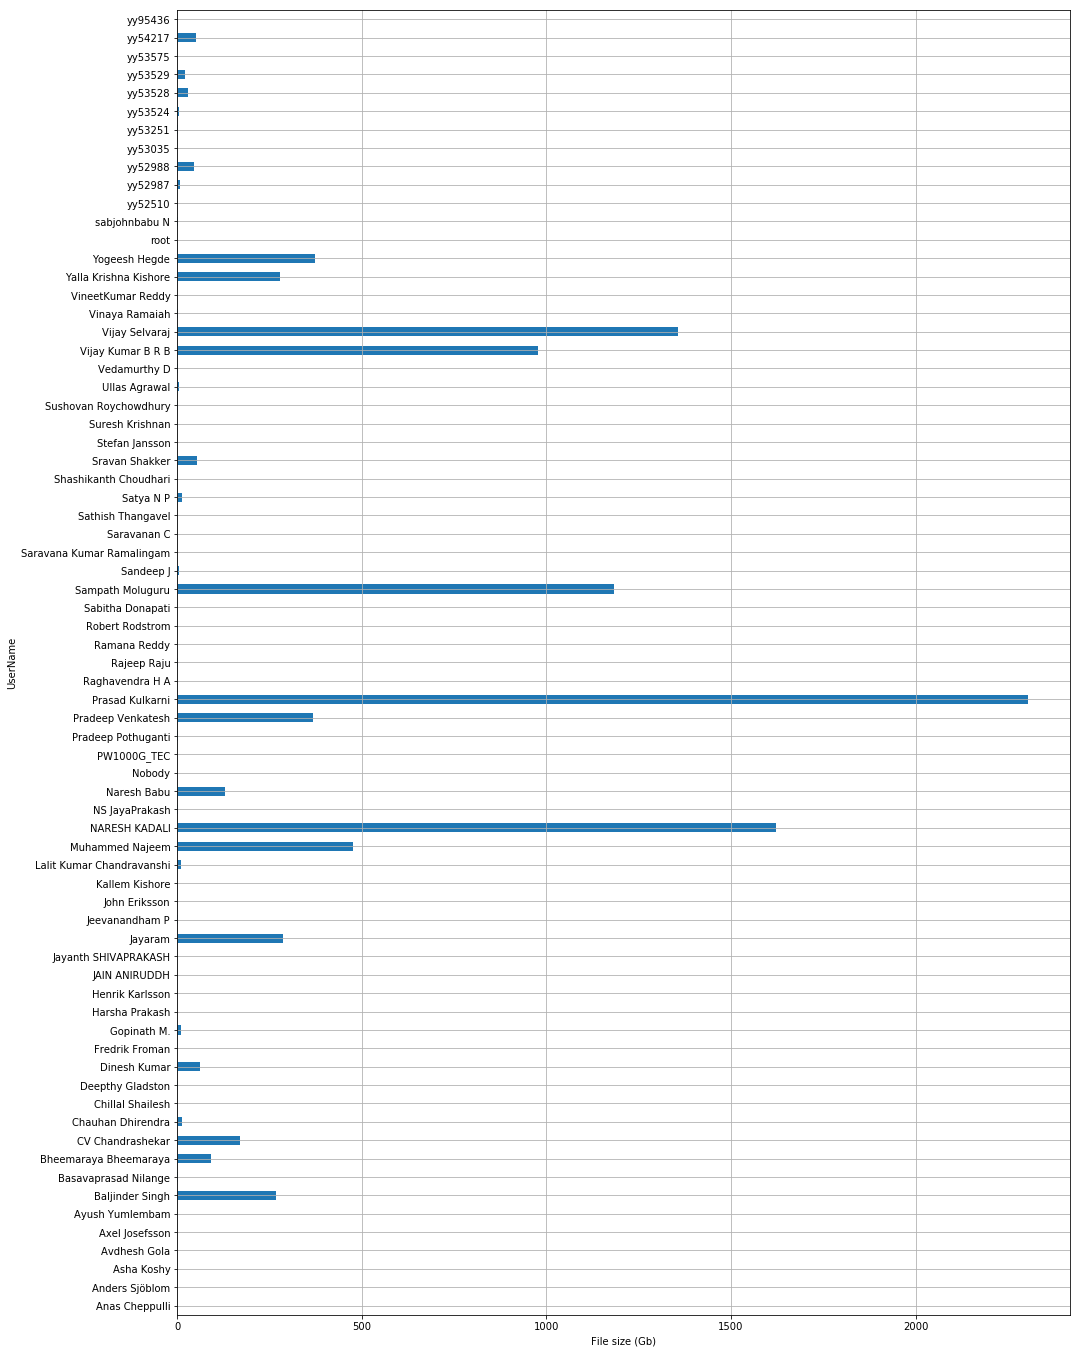

In [33]:
shout("Disk Usage by User")
ax = files.groupby('UserName').Size.sum().plot(kind='barh', grid=True, figsize=(16,len(files.User.unique())/3))
ax.set_xlabel("File size (Gb)");

In [34]:
topjunkcount = 50
shout("{} Largest junk files".format(topjunkcount))
topjunk = files[files.Junk].nlargest(topjunkcount, "Size")
shout("Total size : {}".format(round(topjunk.Size.sum(),1)))
topjunk

,Folder,File,Size,User,DateAccessed,DateModified,Depth,Sparseness,ItemType,UserName,Type,Junk
384078,./BA_IMC/MRB/Vols_10164904_IMC_25BLD_HardTool_EIS/24K_IMC_Casting_Imperfections_Study/FW_IMC_Flange/Ansys,F00_01_LCF_BA_FW5379945_Redesign.esav,8.26,54622,2018-11-06 17:37:45.040507,2018-09-21 09:07:54.000000,7.0,1,f,NARESH KADALI,.esav,True
384086,./BA_IMC/MRB/Vols_10164904_IMC_25BLD_HardTool_EIS/24K_IMC_Casting_Imperfections_Study/FW_IMC_Flange/Ansys,F00_01_LCF_BA_FW5379945_Redesign.osav,8.26,54622,2018-11-06 17:37:45.068266,2018-09-21 08:48:19.000000,7.0,1,f,NARESH KADALI,.osav,True
384074,./BA_IMC/MRB/Vols_10164904_IMC_25BLD_HardTool_EIS/24K_IMC_Casting_Imperfections_Study/FW_IMC_Flange/Ansys,F00_01_LCF_BA_FW5379945_Redesign.full,7.82,54622,2018-11-16 11:27:46.086511,2018-09-21 09:07:54.000000,7.0,1,f,NARESH KADALI,.full,True
386318,./BA_IMC/MRB/Vols_10164904_IMC_25BLD_HardTool_EIS/24K_IMC_Casting_Imperfections_Study/FWD_Flange/Break_edge_model/Pretension,vols_10233495_L00_01_IMC_Fwd_Flg_break_edge_preload_8194N.full,7.05,54611,2018-11-19 10:44:05.042083,2018-11-16 21:27:46.000000,8.0,1,f,Pradeep Venkatesh,.full,True
384041,./BA_IMC/MRB/Vols_10164904_IMC_25BLD_HardTool_EIS/24K_IMC_Casting_Imperfections_Study/FW_IMC_Flange/Ansys,F00_01_LCF_BA_FW5379945_Redesign.PC6,6.72,54622,2018-11-06 17:37:45.036399,2018-09-21 08:49:48.000000,7.0,1,f,NARESH KADALI,.PC6,True
385614,./BA_IMC/MRB/Vols_10164904_IMC_25BLD_HardTool_EIS/24K_IMC_Casting_Imperfections_Study/FWD_Flange/Prel,vols_10233495_L00_01_IMC_Fwd_Flange_preload_8194N.full,6.47,54622,2018-11-19 10:44:26.069479,2018-11-01 02:05:07.000000,7.0,1,f,NARESH KADALI,.full,True
386066,./BA_IMC/MRB/Vols_10164904_IMC_25BLD_HardTool_EIS/24K_IMC_Casting_Imperfections_Study/FWD_Flange/OD_Cracked_FWD_Flange,vols_10233495_L00_01_IMC_Fwd_Flange_preload_8194N.full,6.21,54622,2018-11-29 14:21:16.037325,2018-10-31 15:29:13.000000,7.0,1,f,NARESH KADALI,.full,True
77982,./NSAIMC/A320NEO/MRB/VOLS_10215992_NEO_NCR/temp/2018/enginemount_aug_22/run_nc,EM_NC.full,5.49,53994,2018-08-29 14:34:33.087157,2018-08-23 10:13:37.000000,9.0,1,f,CV Chandrashekar,.full,True
78032,./NSAIMC/A320NEO/MRB/VOLS_10215992_NEO_NCR/temp/2018/enginemount_aug_22/run_novoid,novoid.full,5.47,53994,2018-08-29 14:57:10.077261,2018-08-23 10:19:43.000000,9.0,1,f,CV Chandrashekar,.full,True
386311,./BA_IMC/MRB/Vols_10164904_IMC_25BLD_HardTool_EIS/24K_IMC_Casting_Imperfections_Study/FWD_Flange/Break_edge_model/Pretension,vols_10233495_L00_01_IMC_Fwd_Flg_break_edge_preload_8194N.osav,3.55,54611,2018-11-19 10:44:05.048560,2018-11-16 21:08:15.000000,8.0,1,f,Pradeep Venkatesh,.osav,True


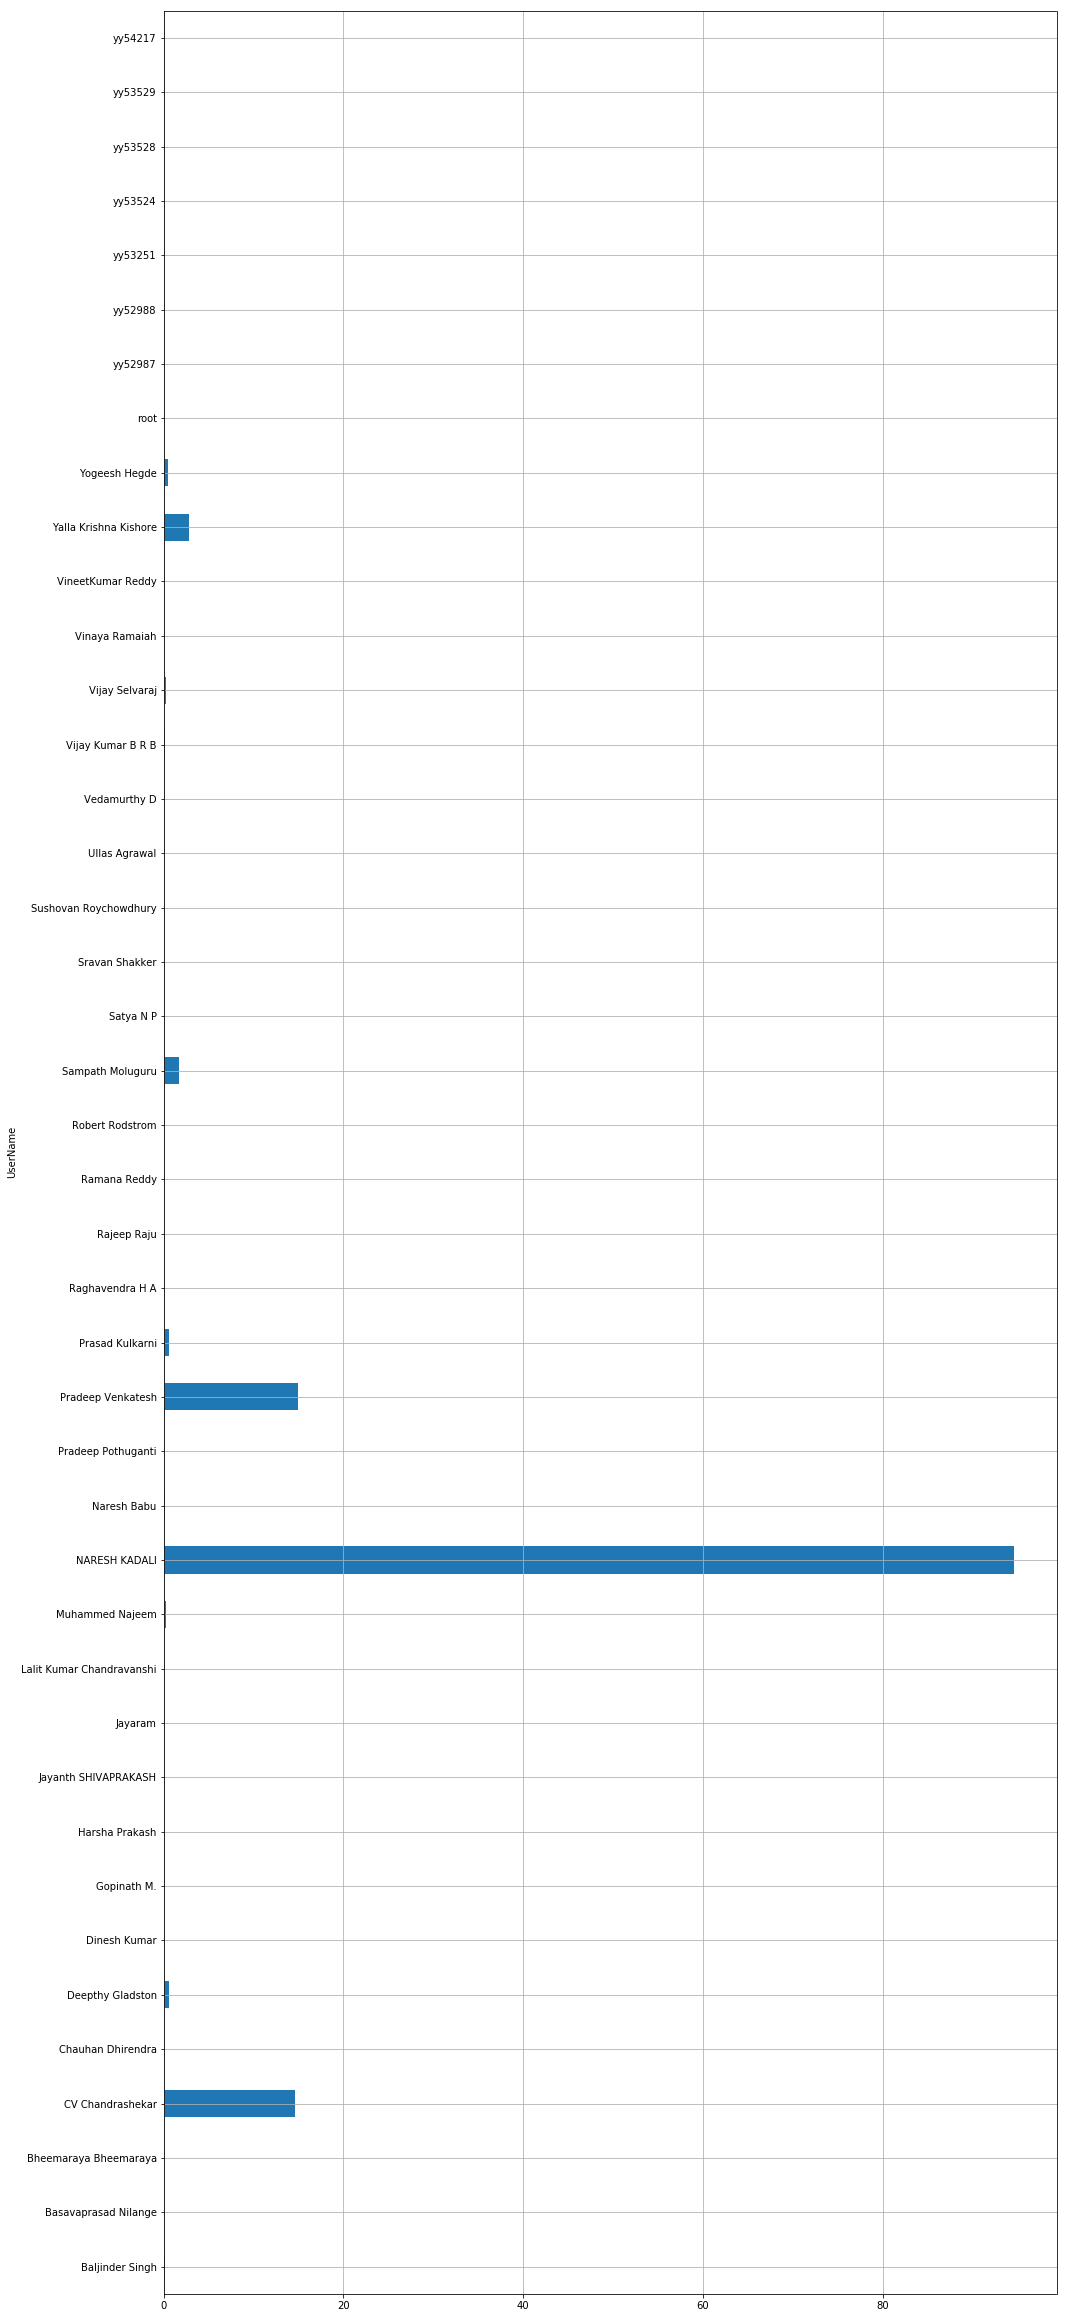

In [35]:
junks = files[files.Junk]
if len(junks):
    shout("Possible Junk Files, per user (Size)")
    junks.groupby("UserName").Size.sum().plot(kind='barh', grid=True, figsize=(16,len(junks.User.unique())))
    ax.set_xlabel("File size (Gb)");
else:
    shout("Hurray! No Junk Files!!")

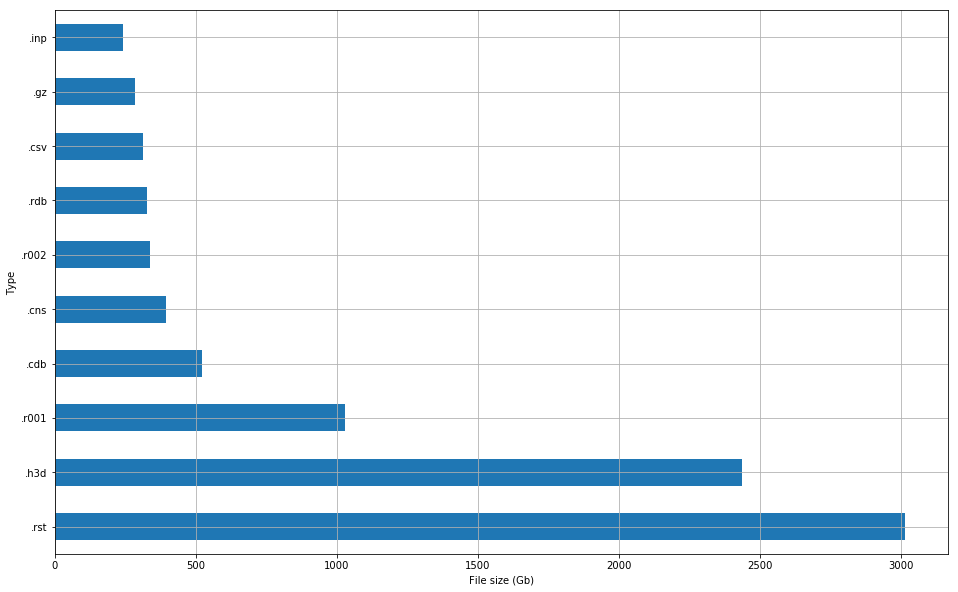

In [36]:
shout("Disk Usage by major file type (Size)")
ax = files.groupby('Type').Size.sum().nlargest(10).plot(kind='barh', grid=True, figsize=(16,10))
ax.set_xlabel("File size (Gb)");

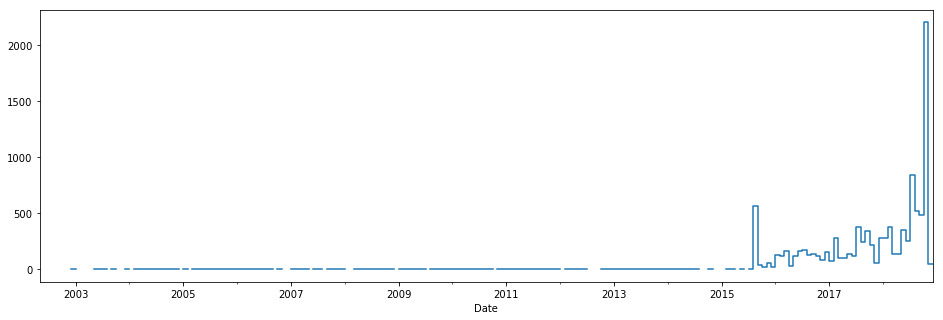

In [37]:
shout("Files Last Accessed Date (Size)")
ax = files.set_index("DateAccessed").resample('M').sum().Size.plot(drawstyle='steps', figsize=(16,5))
ax.set_xlabel("Date");

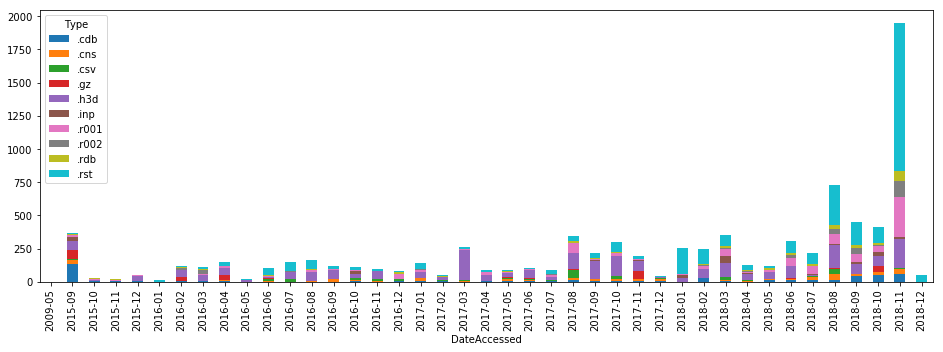

In [38]:
shout("Files Last Accessed time by type")
large_types = list(files.groupby("Type").Size.sum().nlargest(10).index)
files[files.Type.isin(large_types)].groupby(
    by=[files.DateAccessed.dt.to_period('M'), 'Type']
        ).Size.sum().unstack(level=1).plot(kind='bar', figsize=(16,5), stacked=True);

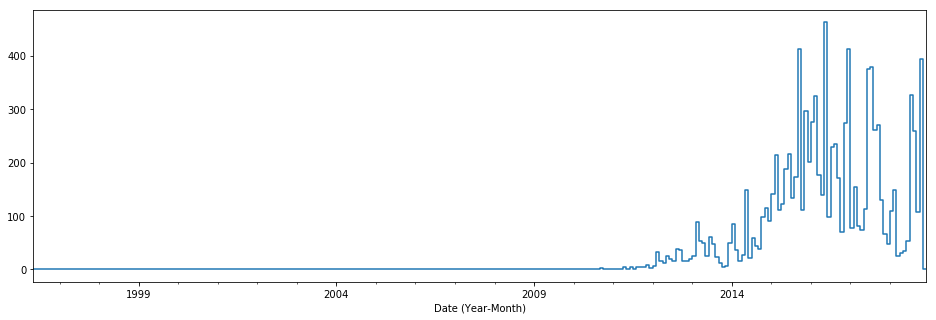

In [40]:
shout("Files Modified Date (Size)")
ax = files.groupby(files.DateModified.dt.to_period('M')).Size.sum().plot(drawstyle='steps', figsize=(16,5))
ax.set_xlabel("Date (Year-Month)");

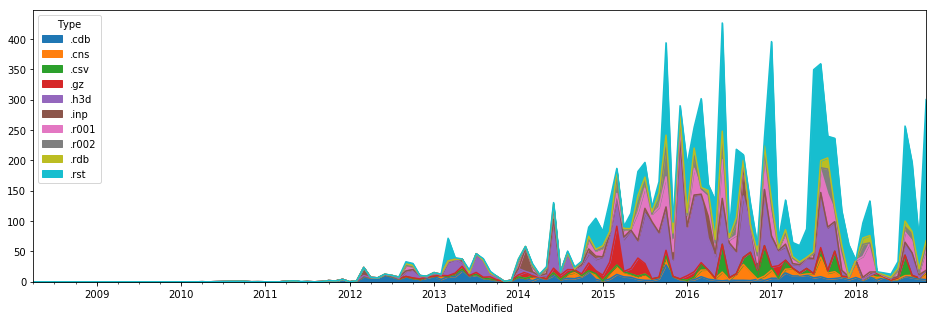

In [41]:
shout("Files Modified time by type (Size)")
large_types = list(files.groupby("Type").Size.sum().nlargest(10).index)
files[files.Type.isin(large_types)].groupby(
    by=[files.DateModified.dt.to_period('M'), 'Type']
        ).Size.sum().unstack(level=1).plot(kind='area', figsize=(16,5), stacked=True);

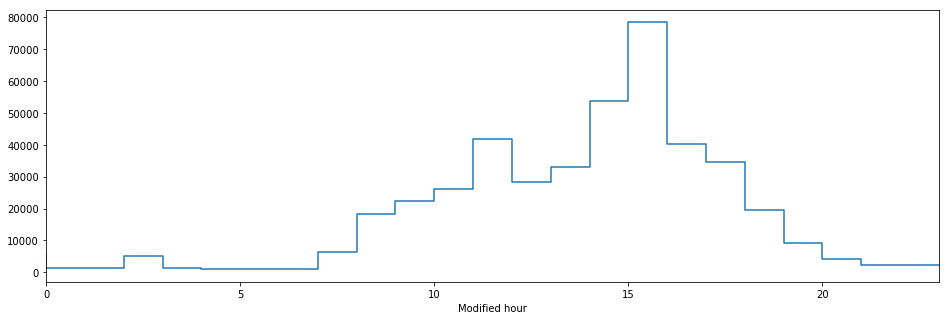

In [43]:
shout("Files Modified time during a day")
ax = files.DateModified.dt.hour.value_counts().sort_index().reindex(range(24)).plot(drawstyle="steps", figsize=(16,5))
ax.set_xlabel("Modified hour");

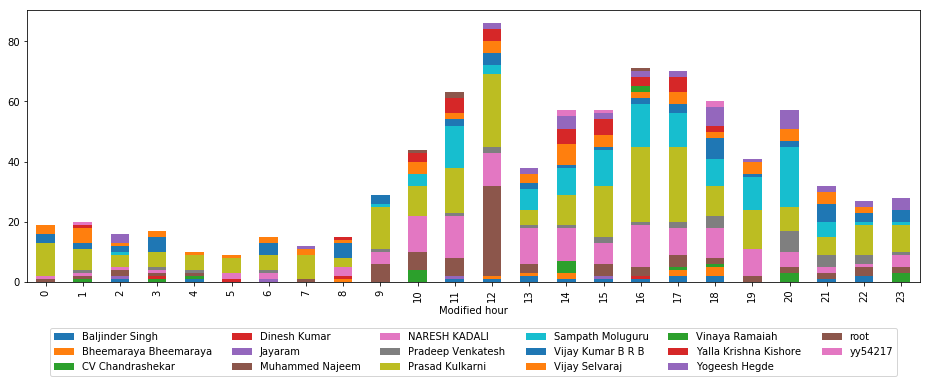

In [44]:
shout("Who fires run when? (RST file creation time in a day)")
ax = files[files.Type == '.rst'].groupby(by=[files.DateModified.dt.hour, 'UserName']).Size.count().unstack(level=1).plot(kind='bar', stacked=True, figsize=(16, 5))
ax.set_xlabel("Modified hour");
ax.legend(loc=9, bbox_to_anchor=(0.5, -0.15), ncol=6);

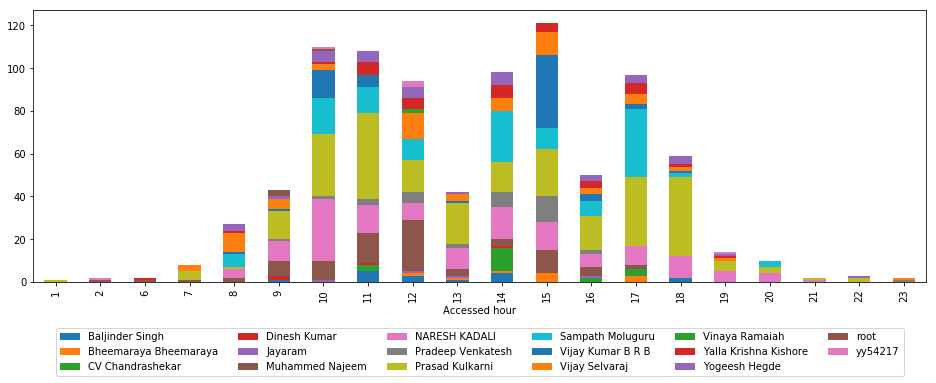

In [45]:
shout("File access time during the day (count)")
ax = files[files.Type == '.rst'].groupby(by=[files.DateAccessed.dt.hour, 'UserName']).Size.count().unstack(level=1).plot(kind='bar', stacked=True, figsize=(16, 5))
ax.set_xlabel("Accessed hour");
ax.legend(loc=9, bbox_to_anchor=(0.5, -0.15), ncol=6);

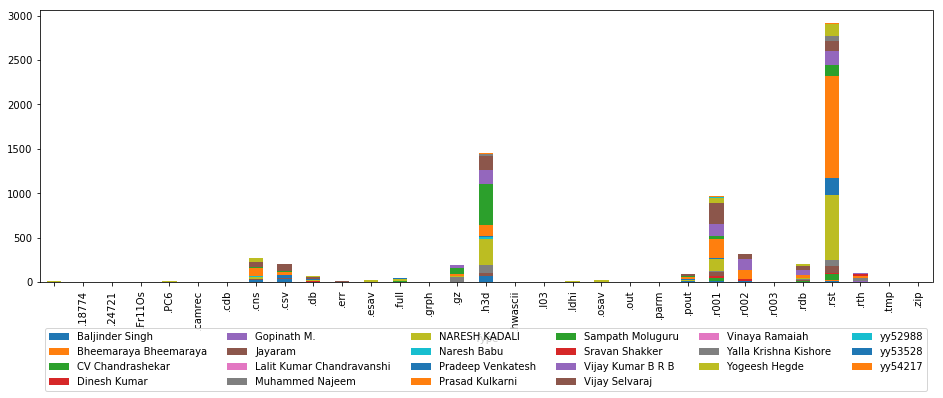

In [46]:
shout("File types and Users (Size)")
ax = files[files.Size > 1].groupby(by=['Type', 'UserName']).Size.sum().unstack(level=1).plot(kind='bar', stacked=True, figsize=(16, 5))
ax.set_xlabel("Type");
ax.legend(loc=9, bbox_to_anchor=(0.5, -0.15), ncol=6);

In [47]:
shout("Run time of each *.rst file")

In [48]:
import numpy as np

In [49]:
def runtime(outfile):
    found=False
    for line in open(outfile, "rb"):
        if b"Elapsed Time (sec)" in line:
            for t in line.split():
                try:
                    time=float(t)                    
                    found=True
                    break
                except ValueError:
                    pass
    if found:
        return time
    else:
        return np.nan

In [50]:
for index, row in files[files.Type == ".rst"].iterrows():
    out_path = os.path.join(folder_path, row["Folder"].strip(), os.path.splitext(row["File"].strip())[0] + ".out")
    ans_path = os.path.join(folder_path, row["Folder"].strip(), os.path.splitext(row["File"].strip())[0] + ".ans")
    if os.path.isfile(out_path):
        files.loc[index, "RunTime"] = runtime(out_path)
    if os.path.isfile(ans_path):
        files.loc[index, "AnsFile"] = True
    else:
        files.loc[index, "AnsFile"] = False

In [51]:
shout("Files which will take less than an hour to run")
shout("*AnsFile status will tell if the corresponding ansys run script is available or not", size="h3")
files.loc[files.RunTime < 3600, ["Size", "RunTime", "AnsFile", "Folder", "File"]].nlargest(50, "Size")

,Size,RunTime,AnsFile,Folder,File
155943,2.68,3043.0,True,./NSAIMC/A320NEO/G5_G6/vols_10191186_block2_comp_6/FL2_01_LPC4_flange/Max_TL_LC_@TO/global,Global_LCF_Cut-Out_L1.25-R1.5_01.rst
156407,2.68,2568.0,True,./NSAIMC/A320NEO/G5_G6/vols_10191186_block2_comp_6/FL2_01_LPC4_flange/Global/LCF/Study_Load_transfer/Actual,Global_Bld5_LCF_crit_Actual.rst
432117,2.42,3090.0,True,./BA_IMC/G5_G6/Vols_10164904_IMC_25BLD_HardTool/Analyses/F00_LCF,vols_10164904_F00_01_IMC_25BLD_HT_LCF_lc23.rst
432164,2.42,3134.0,True,./BA_IMC/G5_G6/Vols_10164904_IMC_25BLD_HardTool/Analyses/F00_LCF,vols_10164904_F00_01_IMC_25BLD_HT_LCF_lc03.rst
165344,2.32,2912.0,True,./NSAIMC/A320NEO/G5_G6/From_nobackup/30K_Eng5_Eflg_cert_loads/Global/NORMAL,Eflange_NORMAL_Run.rst
165353,2.32,3282.0,True,./NSAIMC/A320NEO/G5_G6/From_nobackup/30K_Eng5_Eflg_cert_loads/Global/LIMIT,Vols_10191185_Eflange_LIMIT_Run.rst
165356,2.32,3287.0,True,./NSAIMC/A320NEO/G5_G6/From_nobackup/30K_Eng5_Eflg_cert_loads/Global/ULTIMATE,Vols_10191185_Eflange_ULTIMATE_Run.rst
120434,2.25,2905.0,True,./NSAIMC/A320NEO/MRB/VOLS_10215992_NEO_NCR/224_ATH13615_QN200270435_6018_Blend_at_Strut_4/Analysis/LCF/MRB,LCF_analysis_Irkut.rst
120412,2.20,1523.0,True,./NSAIMC/A320NEO/MRB/VOLS_10215992_NEO_NCR/224_ATH13615_QN200270435_6018_Blend_at_Strut_4/Analysis/LCF/Nominal,LCF_analysis_Irkut.rst
423221,2.04,1726.0,True,./BA_IMC/G5_G6/Vols_10228446_IMC_Loop3_CS300/Analysis/U00_01_Ultimate,Vols_10228446_Loop3CS300_IMC_Ultimate.rst


In [112]:
for index, row in files[files.Type == ".rst"].iterrows():
    h3d_path = os.path.join(folder_path, row["Folder"].strip(), os.path.splitext(row["File"].strip())[0] + ".h3d")
    if os.path.isfile(h3d_path):
        files.loc[index, "H3D"] = True
    else:
        files.loc[index, "H3D"] = False

In [117]:
tempfiles = files[(files.Type == '.rst') & (files.H3D)]

In [118]:
shout("RSTs which has a corresponding H3D file")

In [119]:
shout("Total Size: {} Gb".format(tempfiles.Size.sum()))

In [130]:
pd.set_option("display.max_rows", 999)
tempfiles.sort_values('Size', ascending=False)[['Size', 'Folder', 'File', 'UserName']]

,Size,Folder,File,UserName
415314,40.25,./BA_IMC/G5_G6/Vols_10197516_IMC_25BLD_HardTool_Loop2_CS300_loads/Analyses/F10_B3_Flange/Sub,vols_10197516_FL10_01_LCF_B3Flange.rst,NARESH KADALI
423407,40.15,./BA_IMC/G5_G6/Vols_10228446_IMC_Loop3_CS300/Analysis/B00_01_FBO,vols_10228446_B00_01_IMC_BA_Loop3CS300_FBO.rst,Pradeep Venkatesh
425964,38.98,./BA_IMC/G5_G6/Vols_10239483_FW_PW5379945/Analysis/F00_01_LCF,F00_01_LCF_BA_FW5379945_Redesign.rst,NARESH KADALI
422807,35.59,./BA_IMC/G5_G6/Vols_10228446_IMC_Loop3_CS300/Analysis/FL1_E-Flange/LCF/Submodel,Vols_10228446_EFLG_Sub_LCF_combined.rst,NARESH KADALI
428549,32.62,./BA_IMC/G5_G6/Vols_10164904_IMC_25BLD_HardTool/Analyses/F00_02_LCF_PT2580/Runfiles_Strut1_Submodel,vols_10164904_F00_02_IMC_25BLD_HT_LCF_Submodel_Strut1_Pres_Updated.rst,Jayaram
153883,32.08,./NSAIMC/A320NEO/G5_G6/vols_10191186_block2_comp_6/FL2_01_LPC4_flange/Submodel/LCF,SM_LCF_Red_IMC_Cert_1.5Nom.rst,Prasad Kulkarni
422357,29.89,./BA_IMC/G5_G6/Vols_10228446_IMC_Loop3_CS300/Analysis/FL1_E-Flange/Windmill/Assy,vols_10228446_BA_WM_E_Flange_assy.rst,NARESH KADALI
423657,26.57,./BA_IMC/G5_G6/Vols_10228446_IMC_Loop3_CS300/Analysis/Fwd_Flange/Failed_Link/Assy,vols_10228446_Fail_FWDflg_BA_Envelope_Assy_TLL_TLR.rst,NARESH KADALI
415235,25.53,./BA_IMC/G5_G6/Vols_10197516_IMC_25BLD_HardTool_Loop2_CS300_loads/Analyses/F10_B3_Flange/Global/re_submit_2,vols_10164904_F00_01_IMC_25BLD_HT_LCF_run.rst,NARESH KADALI
432148,24.05,./BA_IMC/G5_G6/Vols_10164904_IMC_25BLD_HardTool/Analyses/F00_LCF,vols_10164904_F00_01_IMC_25BLD_HT_LCF.rst,Sampath Moluguru


In [57]:
import datetime

In [64]:
files["DaysSinceLastAccess"] = files.DateAccessed.apply(lambda x: (datetime.datetime.today() - x).days)

In [83]:
shout("Files larger than 5Gb that are not accessed in last two years")

In [84]:
tempfiles = files[(files.Size > 5) & (files.DaysSinceLastAccess > 365*2)]

In [85]:
shout("Total size: {} Gb".format(round(tempfiles.Size.sum())))

In [86]:
tempfiles

,Folder,File,Size,User,DateAccessed,DateModified,Depth,Sparseness,ItemType,UserName,Type,Junk,AnsFile,RunTime,DaysSinceLastAccess
130177,./NSAIMC/A320NEO/G5_G6/vols_10198958_FW_neo_redesign_comp_9/S00_Strength/01_FBO/6and12Oclk_rivet_failed/EDnL_acel_superpose/cns_gen,CNS_EDnL+accel-pret.cns,5.70,53924,2016-04-19 11:39:40.000000,2015-10-12 15:37:05,10.0,1,f,Prasad Kulkarni,.cns,False,NaN,NaN,958
144733,./NSAIMC/A320NEO/G5_G6/vols_10191185_block2_comp_5/FL1_01_E_flange/Submodel/LIMIT/JM,vols_10191185_FL1_01_E_flange_sub-model_LIMIT_gbxefl.rst,6.42,53924,2016-11-30 09:37:12.068366,2015-02-25 20:34:58,9.0,1,f,Prasad Kulkarni,.rst,False,False,25733.0,733
144758,./NSAIMC/A320NEO/G5_G6/vols_10191185_block2_comp_5/FL1_01_E_flange/Submodel/ULTIMATE/JM,E_flange_ULTIMATE_18.rst,8.90,53924,2016-04-19 09:53:06.000000,2015-02-28 18:28:41,9.0,1,f,Prasad Kulkarni,.rst,False,False,NaN,958
144761,./NSAIMC/A320NEO/G5_G6/vols_10191185_block2_comp_5/FL1_01_E_flange/Submodel/ULTIMATE/JM/Linear,vols_10191185_FL1_01_E_flange_sub-model_ULTIMATE_gbxefl.rst,6.42,53924,2016-06-09 15:17:02.012345,2015-02-26 00:09:19,10.0,1,f,Prasad Kulkarni,.rst,False,True,29264.0,906
146039,./NSAIMC/A320NEO/G5_G6/vols_10191186_block2_comp_6/FL6_01_E_flange_WM/Submodel,VOLS_10191186_FL6_01_EIS_Eflng_Sub_WM.h3d.gz,7.78,54235,2016-02-25 11:47:47.029520,2015-06-22 00:47:22,7.0,1,f,Vijay Kumar B R B,.gz,False,NaN,NaN,1012
146065,./NSAIMC/A320NEO/G5_G6/vols_10191186_block2_comp_6/FL6_01_E_flange_WM/Global_runs_WM,VOLS_10191186_EIS_W00_01_IMC.h3d.gz,10.48,54235,2016-02-25 11:48:02.002268,2015-06-17 17:03:51,7.0,1,f,Vijay Kumar B R B,.gz,False,NaN,NaN,1012
152420,./NSAIMC/A320NEO/G5_G6/vols_10191186_block2_comp_6/FL7_01_LPC4_flange_WM,VOLS_10191186_FL7_01_EIS_LPCflng_Sub_WM.h3d.gz,6.37,54235,2016-02-25 11:48:47.015121,2015-06-20 23:13:56,6.0,1,f,Vijay Kumar B R B,.gz,False,NaN,NaN,1012
181466,./NSAIMC/IRKUT/Archive/Analysis/FS2_01_EM_Failed/NomGeometry_StandardBushings/5_DT/Case2,vols_10207183_FS1_01_Case2-RHpin1_LCF.rst,9.99,53924,2016-06-18 16:08:52.000000,2016-06-18 16:06:58,9.0,1,f,Prasad Kulkarni,.rst,False,True,44721.0,897
181477,./NSAIMC/IRKUT/Archive/Analysis/FS2_01_EM_Failed/NomGeometry_StandardBushings/5_DT/Case1,vols_10207183_FS1_01_Case1-TL-Out1_LCF.rst,10.80,53924,2016-06-18 09:41:29.000000,2016-06-18 09:38:29,9.0,1,f,Prasad Kulkarni,.rst,False,True,58995.0,898
181485,./NSAIMC/IRKUT/Archive/Analysis/FS2_01_EM_Failed/NomGeometry_StandardBushings/5_DT/Case3,vols_10207183_FS1_01_Case3-LHpin1_LCF.rst,9.99,53924,2016-06-18 17:34:12.000000,2016-06-18 17:32:05,9.0,1,f,Prasad Kulkarni,.rst,False,True,45573.0,897


In [92]:
shout("RSTs larger than 2Gb with a run script that are not accessed in last two years", size='h2')

In [88]:
tempfiles = files[(files.Size > 2) & (files.DaysSinceLastAccess > 365*2) & (files.Type == '.rst') & (files.AnsFile)]

In [89]:
shout("Total size: {} Gb".format(round(tempfiles.Size.sum())))

In [90]:
tempfiles

,Folder,File,Size,User,DateAccessed,DateModified,Depth,Sparseness,ItemType,UserName,Type,Junk,AnsFile,RunTime,DaysSinceLastAccess
144761,./NSAIMC/A320NEO/G5_G6/vols_10191185_block2_comp_5/FL1_01_E_flange/Submodel/ULTIMATE/JM/Linear,vols_10191185_FL1_01_E_flange_sub-model_ULTIMATE_gbxefl.rst,6.42,53924,2016-06-09 15:17:02.012345,2015-02-26 00:09:19.000000,10.0,1,f,Prasad Kulkarni,.rst,False,True,29264.0,906
165356,./NSAIMC/A320NEO/G5_G6/From_nobackup/30K_Eng5_Eflg_cert_loads/Global/ULTIMATE,Vols_10191185_Eflange_ULTIMATE_Run.rst,2.32,53924,2016-04-19 10:10:54.000000,2015-02-18 16:56:36.000000,8.0,1,f,Prasad Kulkarni,.rst,False,True,3287.0,958
181466,./NSAIMC/IRKUT/Archive/Analysis/FS2_01_EM_Failed/NomGeometry_StandardBushings/5_DT/Case2,vols_10207183_FS1_01_Case2-RHpin1_LCF.rst,9.99,53924,2016-06-18 16:08:52.000000,2016-06-18 16:06:58.000000,9.0,1,f,Prasad Kulkarni,.rst,False,True,44721.0,897
181477,./NSAIMC/IRKUT/Archive/Analysis/FS2_01_EM_Failed/NomGeometry_StandardBushings/5_DT/Case1,vols_10207183_FS1_01_Case1-TL-Out1_LCF.rst,10.80,53924,2016-06-18 09:41:29.000000,2016-06-18 09:38:29.000000,9.0,1,f,Prasad Kulkarni,.rst,False,True,58995.0,898
181485,./NSAIMC/IRKUT/Archive/Analysis/FS2_01_EM_Failed/NomGeometry_StandardBushings/5_DT/Case3,vols_10207183_FS1_01_Case3-LHpin1_LCF.rst,9.99,53924,2016-06-18 17:34:12.000000,2016-06-18 17:32:05.000000,9.0,1,f,Prasad Kulkarni,.rst,False,True,45573.0,897
181523,./NSAIMC/IRKUT/Archive/Analysis/FS2_01_EM_Failed/NomGeometry_StandardBushings/4_LCF/Case2,vols_10207183_FS1_01_Case2-RHpin2_LCF.rst,3.74,53924,2016-10-15 15:09:10.057441,2016-06-17 23:04:48.000000,9.0,1,f,Prasad Kulkarni,.rst,False,True,21009.0,778
181541,./NSAIMC/IRKUT/Archive/Analysis/FS2_01_EM_Failed/NomGeometry_StandardBushings/4_LCF/Case1,vols_10207183_FS1_01_Case1-TL-Out2_LCF.rst,5.98,53924,2016-10-15 15:09:54.098066,2016-06-18 04:50:31.000000,9.0,1,f,Prasad Kulkarni,.rst,False,True,41752.0,778
181582,./NSAIMC/IRKUT/Archive/Analysis/FS2_01_EM_Failed/NomGeometry_StandardBushings/4_LCF/Case3,vols_10207183_FS1_01_Case3-LHpin2_LCF.rst,3.74,53924,2016-07-11 20:20:42.096396,2016-06-17 23:24:17.000000,9.0,1,f,Prasad Kulkarni,.rst,False,True,22162.0,874
181633,./NSAIMC/IRKUT/Archive/Analysis/FS2_01_EM_Failed/NomGeometry_StandardBushings/2_Pressfit/Case2,vols_10207183_FS0_01_presssfit_fs_case2_StdyState_temps_LCF.rst,3.96,53924,2016-10-15 15:08:26.009354,2016-06-15 19:11:33.000000,9.0,1,f,Prasad Kulkarni,.rst,False,True,13669.0,778
181642,./NSAIMC/IRKUT/Archive/Analysis/FS2_01_EM_Failed/NomGeometry_StandardBushings/2_Pressfit/Case1,vols_10207183_FS0_01_presssfit_fs_case1_StdyState_temps_LCF.rst,4.27,53924,2016-10-15 15:08:21.016753,2016-06-15 20:55:49.000000,9.0,1,f,Prasad Kulkarni,.rst,False,True,16597.0,778


In [100]:
shout("Large files which are not the usual large ones")

In [102]:
files[(files.Size > 1) & (~files.Type.isin([
    '.rst','.h3d','.r001', '.r002', '.r003', '.gz', '.rth', '.cns', '.csv',
    '.db', '.rdb', '.pout', '.cdb'
]))]

,Folder,File,Size,User,DateAccessed,DateModified,Depth,Sparseness,ItemType,UserName,Type,Junk,AnsFile,RunTime,DaysSinceLastAccess
77982,./NSAIMC/A320NEO/MRB/VOLS_10215992_NEO_NCR/temp/2018/enginemount_aug_22/run_nc,EM_NC.full,5.49,53994,2018-08-29 14:34:33.087157,2018-08-23 10:13:37.000000,9.0,1,f,CV Chandrashekar,.full,True,NaN,NaN,95
78007,./NSAIMC/A320NEO/MRB/VOLS_10215992_NEO_NCR/temp/2018/enginemount_aug_22/run_nc/press,Nc.full,1.44,53994,2018-08-29 14:33:27.036397,2018-08-23 14:49:04.000000,10.0,1,f,CV Chandrashekar,.full,True,NaN,NaN,95
78032,./NSAIMC/A320NEO/MRB/VOLS_10215992_NEO_NCR/temp/2018/enginemount_aug_22/run_novoid,novoid.full,5.47,53994,2018-08-29 14:57:10.077261,2018-08-23 10:19:43.000000,9.0,1,f,CV Chandrashekar,.full,True,NaN,NaN,95
78046,./NSAIMC/A320NEO/MRB/VOLS_10215992_NEO_NCR/temp/2018/enginemount_aug_22/run_novoid/press,novoid.full,1.42,53994,2018-08-29 14:36:09.028637,2018-08-23 14:46:30.000000,10.0,1,f,CV Chandrashekar,.full,True,NaN,NaN,95
89665,./NSAIMC/A320NEO/MRB/VOLS_10215992_NEO_NCR/227_ATH14292_QN200272861_TL_BoreBlend,core.18774,1.70,53393,2018-11-30 09:46:42.019785,2018-11-20 14:43:55.053744,6.0,0.848708,f,Muhammed Najeem,.18774,False,NaN,NaN,3
89666,./NSAIMC/A320NEO/MRB/VOLS_10215992_NEO_NCR/227_ATH14292_QN200272861_TL_BoreBlend,core.24721,1.37,53393,2018-11-30 09:46:42.030801,2018-11-20 14:43:54.053841,6.0,0.905775,f,Muhammed Najeem,.24721,False,NaN,NaN,3
152815,./NSAIMC/A320NEO/G5_G6/vols_10191186_block2_comp_6/FL2_01_LPC4_flange/LCF_strt_cut_min/with_LPC_case_front/TLL,.nfs000000000008c07b03037728,2.24,53924,2016-04-19 09:40:29.000000,2014-12-08 15:59:05.000000,9.0,1,f,Prasad Kulkarni,,False,NaN,NaN,958
188316,./NSAIMC/IRKUT/G5_G6/VOLS_10207183_Irkut_IMC_cert/FL3_05_B3_FLange/Old/FBO/Submodel,.r001,1.86,52893,2017-10-03 14:54:02.038901,2017-09-13 10:13:23.094869,9.0,1,f,Bheemaraya Bheemaraya,,False,NaN,NaN,425
199938,./NSAIMC/IRKUT/G5_G6/VOLS_10215817_Irkut_FW_P107/S00_03_Strength/02_Windmill/PWlife,Irkut_WM_PWlife_smooth.tmp,2.03,54191,2018-06-07 16:06:49.000606,2017-10-26 14:23:16.055198,8.0,1,f,Vijay Selvaraj,.tmp,False,NaN,NaN,178
264523,./Temp/Prasad/Scripts/cns_to_HWascii,CNS_MRJ_FW_loopt_1pt7_FBO_EDnL.hwascii,1.96,53924,2017-02-16 11:39:49.004558,2016-07-29 17:52:27.000000,5.0,1,f,Prasad Kulkarni,.hwascii,False,NaN,NaN,655


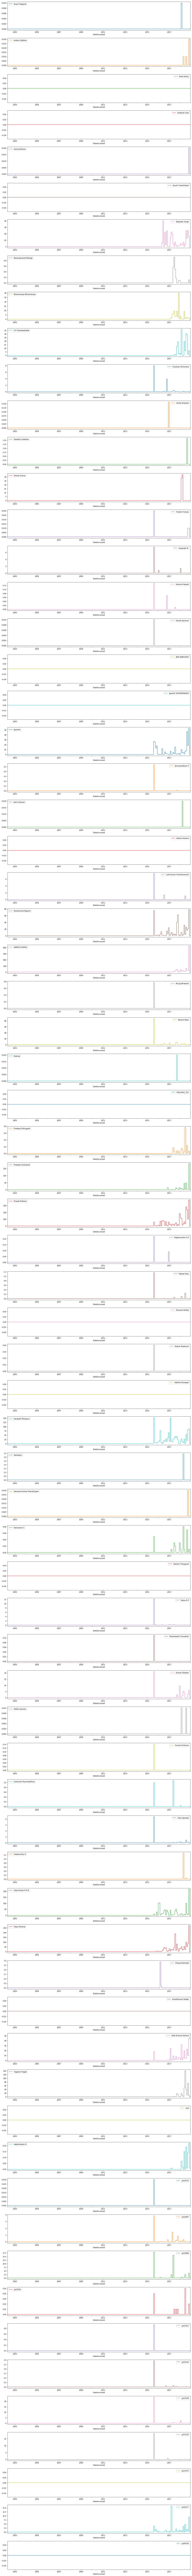

In [39]:
shout("Files last access times, grouped by Owner (Size)")
df = files.groupby(
    by=[files.DateAccessed.dt.to_period('M'), 'UserName']
        ).Size.sum().unstack(level=1).fillna(0)
for plot in df.plot(drawstyle="steps", figsize=(16,len(df.columns)*3), subplots=True, sharex=False, ):
    plot.set_title("")
plt.tight_layout()

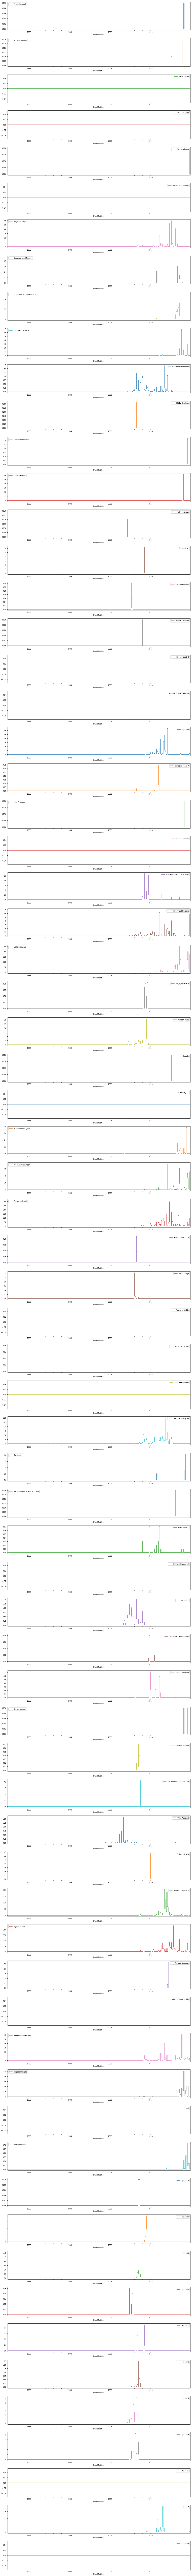

In [42]:
shout("Files Modified grouped by Owner")
df = files.groupby(
    by=[files.DateModified.dt.to_period('M'), 'UserName']
        ).Size.sum().unstack(level=1).fillna(0)
for plot in df.plot(drawstyle="steps", figsize=(16,len(df.columns)*3), subplots=True, sharex=False, ):
    plot.set_title("")
plt.tight_layout()